<a href="https://colab.research.google.com/github/Amit-712/Breast-Cancer-Prediction/blob/main/BreastCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Understanding
Loading the Dataset

In [1]:
from google.colab import files

uploaded = files.upload()


Saving clasification-roi.rar to clasification-roi.rar


In [2]:
!pip install rarfile
import rarfile

with rarfile.RarFile("/content/clasification-roi.rar") as rf:
    rf.extractall("/content/dataset")


In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import cv2
from torch.utils.data import DataLoader, WeightedRandomSampler


# Define the path to your dataset
data_dir = "/content/dataset/clasification-roi"

# Check the directory structure
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Print the classes available in the train directory
print("Classes in training set:")
print(os.listdir(train_dir))

# Print the classes available in the val directory
print("\nClasses in val set:")
print(os.listdir(val_dir))

# Print the classes available in the test directory
print("\nClasses in test set:")
print(os.listdir(test_dir))

Classes in training set:
['Benign', 'Malignant']

Classes in val set:
['Benign', 'Malignant']

Classes in test set:
['Benign', 'Malignant']


#Anaylzing the dataset
Counting images in each class directory

In [4]:

def count_images(directory):

    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count images in the training set
train_class_counts = count_images(train_dir)
print("Number of images in each class (train):", train_class_counts)

Number of images in each class (train): {'Benign': 61, 'Malignant': 105}


#Displaying sample images from a given directory

Sample images from the 'Benign' class


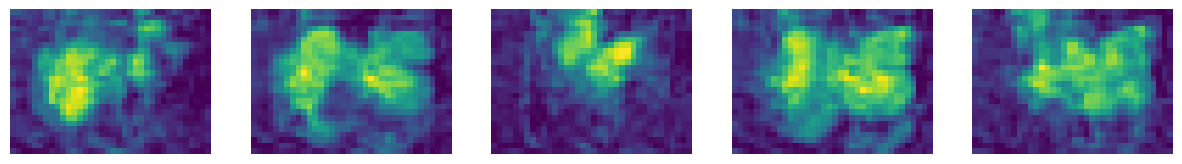

Sample images from the 'Malignant' class


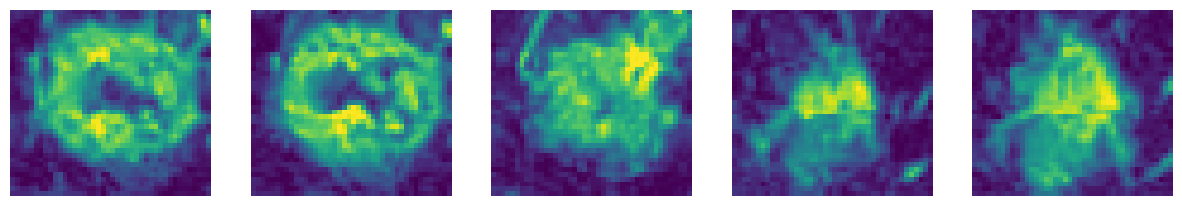

In [5]:
# Displayingg sample images from a given directory
def show_sample_images(class_dir, num_images=5):

    class_images = os.listdir(class_dir)[:num_images]
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(class_images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()


# Defining the train\Benign\BreaDM-Be-1801 directory
benign_images = "/content/dataset/clasification-roi/train/Benign/BreaDM-Be-1801"
img_dir = os.path.join(benign_images, 'SUB1')

malignant_images = "/content/dataset/clasification-roi/train/Malignant/BreaDM-Ma-1802"
img_dir = os.path.join(benign_images, 'SUB2')

# Showing sample images from the 'Benign' class
print("Sample images from the 'Benign' class")
show_sample_images(os.path.join(benign_images, 'SUB1'))


# Showing sample images from the 'Maligant' class
print("Sample images from the 'Malignant' class")
show_sample_images(os.path.join(malignant_images, 'SUB2'))

In [6]:
train_transform = transforms.Compose([
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),  # Increased rotation range
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.RandomGrayscale(p=0.3),  # Increased grayscale probability
    transforms.RandomAffine(degrees=15),  # Slight affine transformations for rotation/translation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [7]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

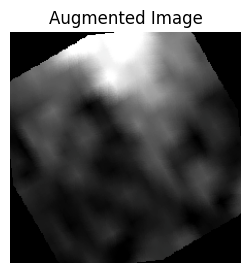

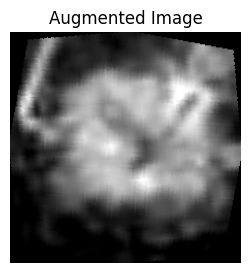

In [8]:
def show_augmented_image(img_path):
    # Open the image
    image = Image.open(img_path)

    # Converting the image to RGB if it’s in a different mode
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Applying the augmentation transformations
    augmented_image = train_transform(image)

    # Convert back to numpy for visualization
    img = augmented_image.permute(1, 2, 0)  # Change from (Channels, Height, Width) to (Height, Width, Channels)

    # Unnormalize the image for visualization
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clamp(0, 1)  # Clamp the values to [0, 1]

    # Plot the image
    plt.figure(figsize=(4, 3))
    plt.imshow(img)
    plt.title("Augmented Image")
    plt.axis('off')
    plt.show()

# Example image paths for Benign and Malignant classes
benign_example_path = "/content/dataset/clasification-roi/train/Benign/BreaDM-Be-1801/SUB1/p-032.jpg"
malignant_example_path = "/content/dataset/clasification-roi/train/Malignant/BreaDM-Ma-1802/SUB1/p-035.jpg"

# Show augmented images
show_augmented_image(benign_example_path)
show_augmented_image(malignant_example_path)

In [9]:
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

data_dir = "/content/dataset/clasification-roi"
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=test_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=test_transform)

In [10]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# Check the size of each dataset
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')

Training set size: 20434
Validation set size: 1989
Test set size: 6851


In [11]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):

        self.patience = patience # How long to wait after last time validation loss improved.
        self.verbose = verbose #If true, prints a message for each validation loss improvement.
        self.delta = delta # Minimum change in monotered quality to quantofy improvement
        self.path = path # file path for saving the model checkpoint
        self.trace_func = trace_func # fun to output message
        self.counter = 0 # track of epochs with no improvement.
        self.best_score = None #store the best score
        self.early_stop = False #indicating whether to stop training.
        self.val_loss_min = np.inf # store the minimum validation loss encountered during training
        #self.best_epoch = 0 #The epoch number of the best model.
        #Epoch is used to describe one complete pass through the entire training dataset.


    def __call__(self, val_loss, model):
        # method is called at end of each epoch to check if the validation loss has improved.
        score = -val_loss

        if self.best_score is None:
            self.best_score = score #the current score is set as the best score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

# checkpoint methond
    def save_checkpoint(self, val_loss, model):

        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). save model')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

model_name = 'vgg16'
#Customvgg16 class inherit from nn.Module
class CustomVGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomVGG16, self).__init__()

        # Loading pre-trained VGG16 model from tourchvision.models
        vgg16 = models.vgg16(pretrained=True)

        # Extracting the features and avgpool layers frm pretrainedmodel
        self.features = vgg16.features
        self.avgpool = vgg16.avgpool

        # Define a new classifier nn.Sequential
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), #input and output
            nn.ReLU(inplace=True), #for activation
            nn.Dropout(), #for regularization
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):

        x = self.features(x) # Passing the input through the features layer
        x = self.avgpool(x) # Using the avgpool layer
        x = torch.flatten(x, 1) # Reshaping the output to a 2D tensor
        x = self.classifier(x) # Passing the reshaped output to the custom classifier
        return x

# printing model
if __name__ == "__main__":
    model = CustomVGG16(num_classes=2)
    print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 83.7MB/s]


CustomVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(5, 5))
    #cmap = sns.color_palette(["#7469B6","#D7B26D" ,"#AD88C6", "#E1AFD1", "#FFE6E6"], as_cmap=True)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Pastel1', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_auc(fpr, tpr, auc_score):
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='#D20062', lw=2, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], color='#D1BB9E', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extracting labels from the training dataset
train_labels = [label for _, label in train_dataset.samples]

# Computing class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.FloatTensor(class_weights).to(device)

# loss function to include class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# weighted sampler to handle class imbalance
class_sample_counts = np.bincount(train_labels)
weights = 1. / class_sample_counts
samples_weights = weights[train_labels]
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

#DataLoader with the sampler
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2, drop_last=True)

In [16]:
import torch
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast  # ✅ Use torch.cuda.amp
from tqdm import tqdm

def train(epoch, model, num_epochs, loader, criterion, optimizer, device):
    model.train()
    correct = 0
    total_loss = 0
    scaler = GradScaler()

    for data, label in tqdm(loader, desc=f'Epoch {epoch}/{num_epochs}', unit='batch'):
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()
        with autocast():  # ✅ No device argument here
            output = model(data)
            loss = criterion(output, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    print(f'Train Epoch: {epoch} \tLoss: {avg_loss:.6f} \tAccuracy: {accuracy:.2f}%')

    return avg_loss, accuracy


In [17]:
import torch
import torch.nn.functional as F
from sklearn import metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from torch.cuda.amp import autocast

def validation(model, val_dataloader, criterion, device, plot_metrics=False):
    name = 'val'
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    all_predictions = []
    all_targets = []
    probabilities = []

    with torch.no_grad():  # Ensuring no gradients are computed, saving memory and computation
        for data, target in val_dataloader:
            data, target = data.to(device), target.to(device)
            val_output = model(data)  # Getting model's predictions
            loss = criterion(val_output, target)
            val_loss += loss.item() * data.size(0)  # Calculate the loss
            pred = val_output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            all_predictions.extend(pred.cpu().numpy())  # Gets the predicted class for each input
            probs = F.softmax(val_output, dim=1).cpu().data.numpy()  # Softmax is used to convert the range of values in an array between 0-1

            probabilities.append(probs)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_targets.extend(target.cpu().numpy())  # Collect all target labels

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    probabilities = np.vstack(probabilities)

    cm = metrics.confusion_matrix(all_targets, all_predictions)
    print("Confusion Matrix:\n", cm)


    classification_rep = classification_report(all_targets, all_predictions, target_names=["benign", "malignant"])
    print(f'Classification Report of Validation:\n{classification_rep}\n')

    # One-hot encode the labels for AUC computation
    num_classes = val_output.shape[1]
    label_onehot = np.eye(num_classes)[all_targets.astype(int)]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), probabilities.ravel())
    auc_score = auc(fpr, tpr)

    val_loss /= len(val_dataloader.dataset)
    accuracy = 100. * correct / len(val_dataloader.dataset)

    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_score))
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            val_loss, correct, len(val_dataloader.dataset), accuracy))

    if plot_metrics:
        classification_rep = classification_report(all_targets, all_predictions, target_names=["benign", "malignant"])
        print(f'Classification Report of Validation:\n{classification_rep}\n')

        print("Confusion Matrix of Validation:\n")
        plot_confusion_matrix(cm, classes=['benign', 'malignant'])
        plot_auc(fpr, tpr, auc_score)

    return accuracy, val_loss, auc_score

In [18]:
from sklearn import metrics
import numpy as np
import torch.nn.functional as F

def test(model, test_dataloader, criterion, device):
    name = "test"
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    all_predictions = []
    all_targets = []
    all_probabilities = []

    with torch.no_grad():  # Ensuring no gradients are computed, saving memory and computation.
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)

            test_output = model(data)  # Getting model's predictions
            loss = criterion(test_output, target)
            test_loss += loss.item() * data.size(0)  # Calculate the loss
            pred = test_output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability

            all_predictions.extend(pred.cpu().numpy())  # Gets the predicted class for each input.
            all_targets.extend(target.cpu().numpy())  # Get the true labels
            probabilities = F.softmax(test_output, dim=1).cpu().numpy()  # Softmax is used to convert the range of values in an array between 0-1
            all_probabilities.extend(probabilities)

            correct += pred.eq(target.view_as(pred)).sum().item()

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_probabilities = np.array(all_probabilities)

    # Classification metrics - accuracy, f1 score
    classification_rep = metrics.classification_report(all_targets, all_predictions, target_names=['benign', 'malignant'], digits=4)
    print('Classification Report of Test:')
    print(classification_rep)

    # Compute confusion matrix
    cm = metrics.confusion_matrix(all_targets, all_predictions)
    print('Confusion Matrix:')
    print(cm)
    plot_confusion_matrix(cm, ['benign', 'malignant'])

    # ROC AUC
    num_classes = all_probabilities.shape[1]
    label_onehot = np.eye(num_classes)[all_targets.astype(int)]

    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), all_probabilities.ravel())
    auc_value = metrics.auc(fpr, tpr)
    plot_auc(fpr, tpr, auc_value)

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100. * correct / len(test_dataloader.dataset)
    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_value))
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(name, test_loss, correct, len(test_dataloader.dataset), accuracy))

    return accuracy, test_loss, auc_value

In [19]:
model.to(device)  # here cudu device
model = CustomVGG16(num_classes=2).to(device)
best_accuracy = 0
total_epochs = 20
momentum = 0.9
no_cuda = False
log_interval = 10
model_name = "vgg16"
# Define optimizer and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


<ipython-input-16-662cc997996a>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/25:   0%|          | 0/319 [00:00<?, ?batch/s]<ipython-input-16-662cc997996a>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ No device argument here
Epoch 1/25: 100%|██████████| 319/319 [02:46<00:00,  1.91batch/s]

Train Epoch: 1 	Loss: 0.293908 	Accuracy: 80.79%


Confusion Matrix:
 [[ 340   68]
 [ 264 1312]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.56      0.83      0.67       408
   malignant       0.95      0.83      0.89      1576

    accuracy                           0.83      1984
   macro avg       0.76      0.83      0.78      1984
weighted avg       0.87      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9194

Validation set: Average loss: 0.4493, Accuracy: 1652/1989 (83.06%)

Best model saved with AUC 0.9194 at epoch 1 to ./vgg16_Model/vgg16_best.pth
Validation loss decreased (inf --> 0.449299). save model


<ipython-input-16-662cc997996a>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 2/25:   0%|          | 0/319 [00:00<?, ?batch/s]<ipython-input-16-662cc997996a>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ No device argument here
Epoch 2/25: 100%|██████████| 319/319 [02:46<00:00,  1.92batch/s]

Train Epoch: 2 	Loss: 0.295218 	Accuracy: 80.58%


Confusion Matrix:
 [[ 340   68]
 [ 259 1317]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.83      0.68       408
   malignant       0.95      0.84      0.89      1576

    accuracy                           0.84      1984
   macro avg       0.76      0.83      0.78      1984
weighted avg       0.87      0.84      0.85      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9202

Validation set: Average loss: 0.4469, Accuracy: 1657/1989 (83.31%)

Best model saved with AUC 0.9202 at epoch 2 to ./vgg16_Model/vgg16_best.pth
Validation loss decreased (0.449299 --> 0.446950). save model


<ipython-input-16-662cc997996a>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 3/25:   0%|          | 0/319 [00:00<?, ?batch/s]<ipython-input-16-662cc997996a>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ No device argument here
Epoch 3/25: 100%|██████████| 319/319 [02:47<00:00,  1.91batch/s]

Train Epoch: 3 	Loss: 0.295122 	Accuracy: 80.85%



<ipython-input-16-662cc997996a>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Confusion Matrix:
 [[ 341   67]
 [ 263 1313]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.56      0.84      0.67       408
   malignant       0.95      0.83      0.89      1576

    accuracy                           0.83      1984
   macro avg       0.76      0.83      0.78      1984
weighted avg       0.87      0.83      0.84      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9192

Validation set: Average loss: 0.4512, Accuracy: 1654/1989 (83.16%)

EarlyStopping counter: 1 out of 5


Epoch 4/25:   0%|          | 0/319 [00:00<?, ?batch/s]<ipython-input-16-662cc997996a>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ No device argument here
Epoch 4/25: 100%|██████████| 319/319 [02:46<00:00,  1.91batch/s]

Train Epoch: 4 	Loss: 0.295654 	Accuracy: 80.72%



<ipython-input-16-662cc997996a>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Confusion Matrix:
 [[ 341   67]
 [ 260 1316]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.84      0.68       408
   malignant       0.95      0.84      0.89      1576

    accuracy                           0.84      1984
   macro avg       0.76      0.84      0.78      1984
weighted avg       0.87      0.84      0.85      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9201

Validation set: Average loss: 0.4472, Accuracy: 1657/1989 (83.31%)

EarlyStopping counter: 2 out of 5


Epoch 5/25:   0%|          | 0/319 [00:00<?, ?batch/s]<ipython-input-16-662cc997996a>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ No device argument here
Epoch 5/25: 100%|██████████| 319/319 [02:45<00:00,  1.93batch/s]

Train Epoch: 5 	Loss: 0.305065 	Accuracy: 79.91%


Confusion Matrix:
 [[ 340   68]
 [ 256 1320]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.83      0.68       408
   malignant       0.95      0.84      0.89      1576

    accuracy                           0.84      1984
   macro avg       0.76      0.84      0.78      1984
weighted avg       0.87      0.84      0.85      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9212

Validation set: Average loss: 0.4425, Accuracy: 1660/1989 (83.46%)

Model saved at epoch 5 to ./vgg16_Model/vgg16_epoch_5.pth
Best model saved with AUC 0.9212 at epoch 5 to ./vgg16_Model/vgg16_best.pth
Validation loss decreased (0.446950 --> 0.442512). save model


<ipython-input-16-662cc997996a>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 6/25:   0%|          | 0/319 [00:00<?, ?batch/s]<ipython-input-16-662cc997996a>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ No device argument here
Epoch 6/25: 100%|██████████| 319/319 [02:47<00:00,  1.90batch/s]

Train Epoch: 6 	Loss: 0.293895 	Accuracy: 80.69%


Confusion Matrix:
 [[ 340   68]
 [ 253 1323]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.83      0.68       408
   malignant       0.95      0.84      0.89      1576

    accuracy                           0.84      1984
   macro avg       0.76      0.84      0.79      1984
weighted avg       0.87      0.84      0.85      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9216

Validation set: Average loss: 0.4407, Accuracy: 1663/1989 (83.61%)

Best model saved with AUC 0.9216 at epoch 6 to ./vgg16_Model/vgg16_best.pth
Validation loss decreased (0.442512 --> 0.440688). save model


<ipython-input-16-662cc997996a>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 7/25:   0%|          | 0/319 [00:00<?, ?batch/s]<ipython-input-16-662cc997996a>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ No device argument here
Epoch 7/25: 100%|██████████| 319/319 [02:47<00:00,  1.90batch/s]

Train Epoch: 7 	Loss: 0.298877 	Accuracy: 80.63%



<ipython-input-16-662cc997996a>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Confusion Matrix:
 [[ 340   68]
 [ 253 1323]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.83      0.68       408
   malignant       0.95      0.84      0.89      1576

    accuracy                           0.84      1984
   macro avg       0.76      0.84      0.79      1984
weighted avg       0.87      0.84      0.85      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9216

Validation set: Average loss: 0.4410, Accuracy: 1663/1989 (83.61%)

EarlyStopping counter: 1 out of 5


Epoch 8/25:   0%|          | 0/319 [00:00<?, ?batch/s]<ipython-input-16-662cc997996a>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ No device argument here
Epoch 8/25: 100%|██████████| 319/319 [02:47<00:00,  1.90batch/s]

Train Epoch: 8 	Loss: 0.300222 	Accuracy: 80.70%



<ipython-input-16-662cc997996a>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Confusion Matrix:
 [[ 340   68]
 [ 255 1321]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.83      0.68       408
   malignant       0.95      0.84      0.89      1576

    accuracy                           0.84      1984
   macro avg       0.76      0.84      0.78      1984
weighted avg       0.87      0.84      0.85      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9215

Validation set: Average loss: 0.4411, Accuracy: 1661/1989 (83.51%)

EarlyStopping counter: 2 out of 5


Epoch 9/25:   0%|          | 0/319 [00:00<?, ?batch/s]<ipython-input-16-662cc997996a>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ No device argument here
Epoch 9/25: 100%|██████████| 319/319 [02:46<00:00,  1.91batch/s]

Train Epoch: 9 	Loss: 0.299283 	Accuracy: 80.64%



<ipython-input-16-662cc997996a>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Confusion Matrix:
 [[ 340   68]
 [ 256 1320]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.83      0.68       408
   malignant       0.95      0.84      0.89      1576

    accuracy                           0.84      1984
   macro avg       0.76      0.84      0.78      1984
weighted avg       0.87      0.84      0.85      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9215

Validation set: Average loss: 0.4412, Accuracy: 1660/1989 (83.46%)

EarlyStopping counter: 3 out of 5


Epoch 10/25:   0%|          | 0/319 [00:00<?, ?batch/s]<ipython-input-16-662cc997996a>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ No device argument here
Epoch 10/25: 100%|██████████| 319/319 [02:47<00:00,  1.91batch/s]

Train Epoch: 10 	Loss: 0.295535 	Accuracy: 80.78%


Confusion Matrix:
 [[ 340   68]
 [ 256 1320]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.83      0.68       408
   malignant       0.95      0.84      0.89      1576

    accuracy                           0.84      1984
   macro avg       0.76      0.84      0.78      1984
weighted avg       0.87      0.84      0.85      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9215

Validation set: Average loss: 0.4412, Accuracy: 1660/1989 (83.46%)



<ipython-input-16-662cc997996a>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Model saved at epoch 10 to ./vgg16_Model/vgg16_epoch_10.pth
EarlyStopping counter: 4 out of 5


Epoch 11/25:   0%|          | 0/319 [00:00<?, ?batch/s]<ipython-input-16-662cc997996a>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ No device argument here
Epoch 11/25: 100%|██████████| 319/319 [02:47<00:00,  1.90batch/s]

Train Epoch: 11 	Loss: 0.298943 	Accuracy: 80.58%


Confusion Matrix:
 [[ 340   68]
 [ 256 1320]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.83      0.68       408
   malignant       0.95      0.84      0.89      1576

    accuracy                           0.84      1984
   macro avg       0.76      0.84      0.78      1984
weighted avg       0.87      0.84      0.85      1984


Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9214

Validation set: Average loss: 0.4413, Accuracy: 1660/1989 (83.46%)

EarlyStopping counter: 5 out of 5
Early stopping
Confusion Matrix:
 [[ 340   68]
 [ 256 1320]]
Classification Report of Validation:
              precision    recall  f1-score   support

      benign       0.57      0.83      0.68       408
   malignant       0.95      0.84      0.89      1576

    accuracy                           0.84      1984
   macro avg       0.76      0.84      0.78      1984
weighted avg       0.87      0.84      0.85      1984


Specif

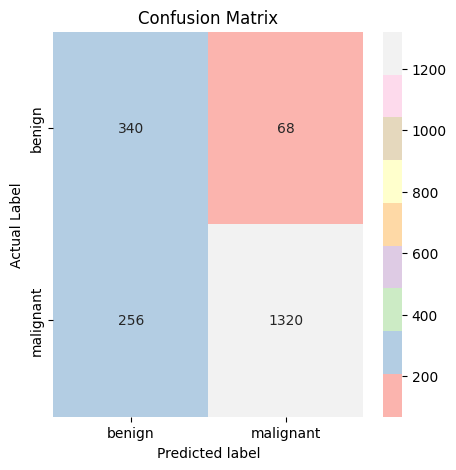

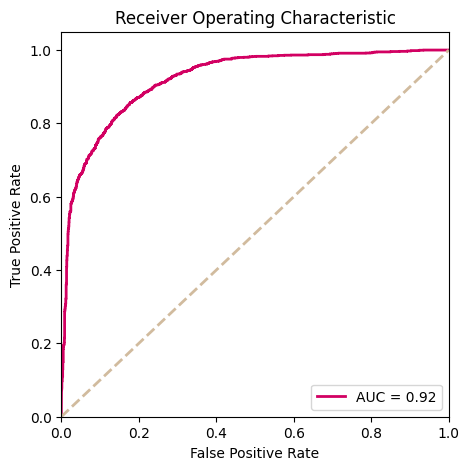

In [21]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Early stopping setup
early_stop = EarlyStopping(patience=5, verbose=True)

best_accuracy = 0
model_save_dir = './VGG16_Model'
model_save_dir = f'./{model_name}_Model'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

for epoch in range(1, total_epochs + 1):
    # Train the model
    train_loss, train_acc = train(epoch, model, total_epochs, train_loader, criterion, optimizer, device)

    with torch.no_grad():
        val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=False)

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Save model every 5 epochs
    if epoch % 5 == 0:
        model_save_path = os.path.join(model_save_dir, f'{model_name}_epoch_{epoch}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved at epoch {epoch} to {model_save_path}')

    if val_auc > best_accuracy:
        best_accuracy = val_auc
        best_model_path = os.path.join(model_save_dir, f'{model_name}_best.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved with AUC {best_accuracy:.4f} at epoch {epoch} to {best_model_path}')

    early_stop(val_loss, model)
    if early_stop.early_stop:
        print("Early stopping")
        with torch.no_grad():
            val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=True)
        break

Testing the model on the test dataset
Classification Report of Test:
              precision    recall  f1-score   support

      benign     0.6613    0.6115    0.6354      1938
   malignant     0.8511    0.8764    0.8635      4910

    accuracy                         0.8014      6848
   macro avg     0.7562    0.7439    0.7495      6848
weighted avg     0.7974    0.8014    0.7990      6848

Confusion Matrix:
[[1185  753]
 [ 607 4303]]


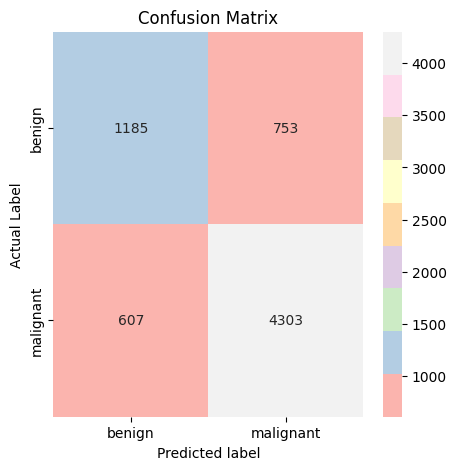

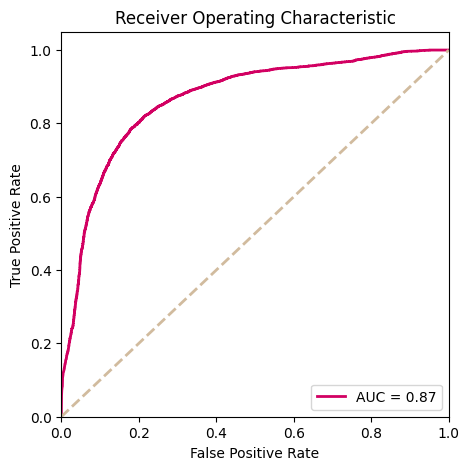

Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8660

test set: Average loss: 0.8659, Accuracy: 5488/6851 (80.11%)



In [22]:
  # Evaluating the model on the test dataset
print("Testing the model on the test dataset")
test_accuracy, test_loss, test_auc = test(model, test_loader, criterion, device)

In [ ]:
!nvidia-smi


Sun Apr  6 09:16:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             33W /   70W |   14520MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
print(next(model.parameters()).device)  # Should show "cuda:0"


cuda:0


In [23]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.4 MB/s eta 0:00:00


In [24]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

import torch
import torch.nn as nn
import torchvision.models as models

model_name = 'vgg16'
#Customvgg16 class inherit from nn.Module
class CustomVGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomVGG16, self).__init__()

        # Loading pre-trained VGG16 model from tourchvision.models
        vgg16 = models.vgg16(pretrained=True)

        # Extracting the features and avgpool layers frm pretrainedmodel
        self.features = vgg16.features
        self.avgpool = vgg16.avgpool

        # Define a new classifier nm.Sequential
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), #input and output
            nn.ReLU(inplace=True), #for activation
            nn.Dropout(), #for regularization
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):

        x = self.features(x) # Passing the input through the features layer
        x = self.avgpool(x) # Using the avgpool layer
        x = torch.flatten(x, 1) # Reshaping the output to a 2D tensor
        x = self.classifier(x) # Passing the reshaped output to the custom classifier
        return x

In [25]:
vgg16_path = '/content/checkpoint.pt'

In [26]:
vgg16_model = CustomVGG16(num_classes=2)
vgg16_model.load_state_dict(torch.load(vgg16_path, map_location = torch.device('cpu')))
vgg16_model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [27]:
# Preprocessing the input image to match your modelss' requirements.

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [30]:
def predict(model_name, image):
    #preprocessing the image
    #adds a new dimension at the 0th position (i.e., the first position).
    img = preprocess(image).unsqueeze(0) # This sets the batch size to 1

    # Select the model
    if model_name == "VGG16":
        model = vgg16_model
    elif model_name == "ResNet18":
        model = resnet18_model
    elif model_name == "ResNet50":
        model = resnet50_model
    else:
        return "Invalid model name"


    # Get the model's prediction
    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)  # Get class index

    # Define class labels
    classes = ["benign", "malignant"]
    return classes[predicted.item()]  # Return the predicted label

In [32]:
import gradio as gr

# Create the interface
interface = gr.Interface(
    fn=predict,  # Function to call for prediction
    inputs=[
        gr.Dropdown(choices=["VGG16"], label="Select Model"),  # Dropdown for model selection
        gr.Image(type="pil")  # Input: Upload an image
    ],
    outputs="label",  # Output: Display the label (benign/malignant)
    title="Tumor Classification",
    description="Select a model and upload an MRI image to classify it as benign or malignant."
)

# Launch the app
interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://aa63dfdf91ef48b10b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
